# Challenge 1: Classification
In this challenge, you're given a food classification dataset which has 101 classes. You need to analyze and preprocess the dataset as well as build deep learning models for performing food classification. 
<br>
Three models are to be trained for this task, mainly light, medium, and heavy model. <br>
Examples: <br>
Light model - mobilenetv2 <br>
Medium model - Resnet50 <br>
Heavy model - VGG19 <br>
<br>
The above given models are examples. You are free to choose any deep learning model to train. 

**Main Objective**:
You are supposed to use both TensorFlow and PyTorch for this task. You need to train one model for each framework. (You can use one of the frameworks again for the third model)

## Summary 

Create a table for your train and test accuracy as well as speed for each model (mention the framework used for training)

# Analyze the dataset
## Objectives
1. Upload the dataset provided (Google Drive link). 
2. Extract the dataset. 
3. Re-arrange dataset into training and testing folders. 
4. List number of samples in training and testing folders. 
5. Plot sample images from training and testing datasets. 


### 0. Importing the required libraries

In [22]:
import os
import cv2
import random
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models

### 1. Uploading the dataset to food-101/data

* Mount the drive to google colab



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 2. Extracting the dataset
* Unzip the folder to the same location

In [23]:
# Extract/unzip the dataset

import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Colab_Notebooks/food-101/data/")

In [ ]:
# delete zip file after extracting the dataset, to save space on drive
#!rm -rf /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/food-101.zip

In [24]:
# checking if still the zip file exists in the folder path
!ls /content/drive/MyDrive/Colab_Notebooks/food-101/data


food-101  food-101.zip


### 3. Re-arrange dataset into training and testing folders.

In [25]:
# Checking the extracted dataset folder contents
!ls /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/

images	meta  README.txt


#### checking the number of folders present inside the dataset and their contents

In [26]:
print(len(os.listdir('/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/images')))
os.listdir('/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/images')

101


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [27]:
# listing the contents inside meta folder
os.listdir('/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

In [28]:
# lets see the first 5 lines of the train.txt
!head /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [29]:
# lets see the first 5 lines of the test.txt
!head /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta/test.txt

apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694
apple_pie/1047447
apple_pie/1068632
apple_pie/110043
apple_pie/1106961
apple_pie/1113017


In [30]:
# lets also see the content inside the classes.txt file
!head /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


#### Lets look at 1 random image from each of the folders of 101 classes split across 8 columns and 13 rows

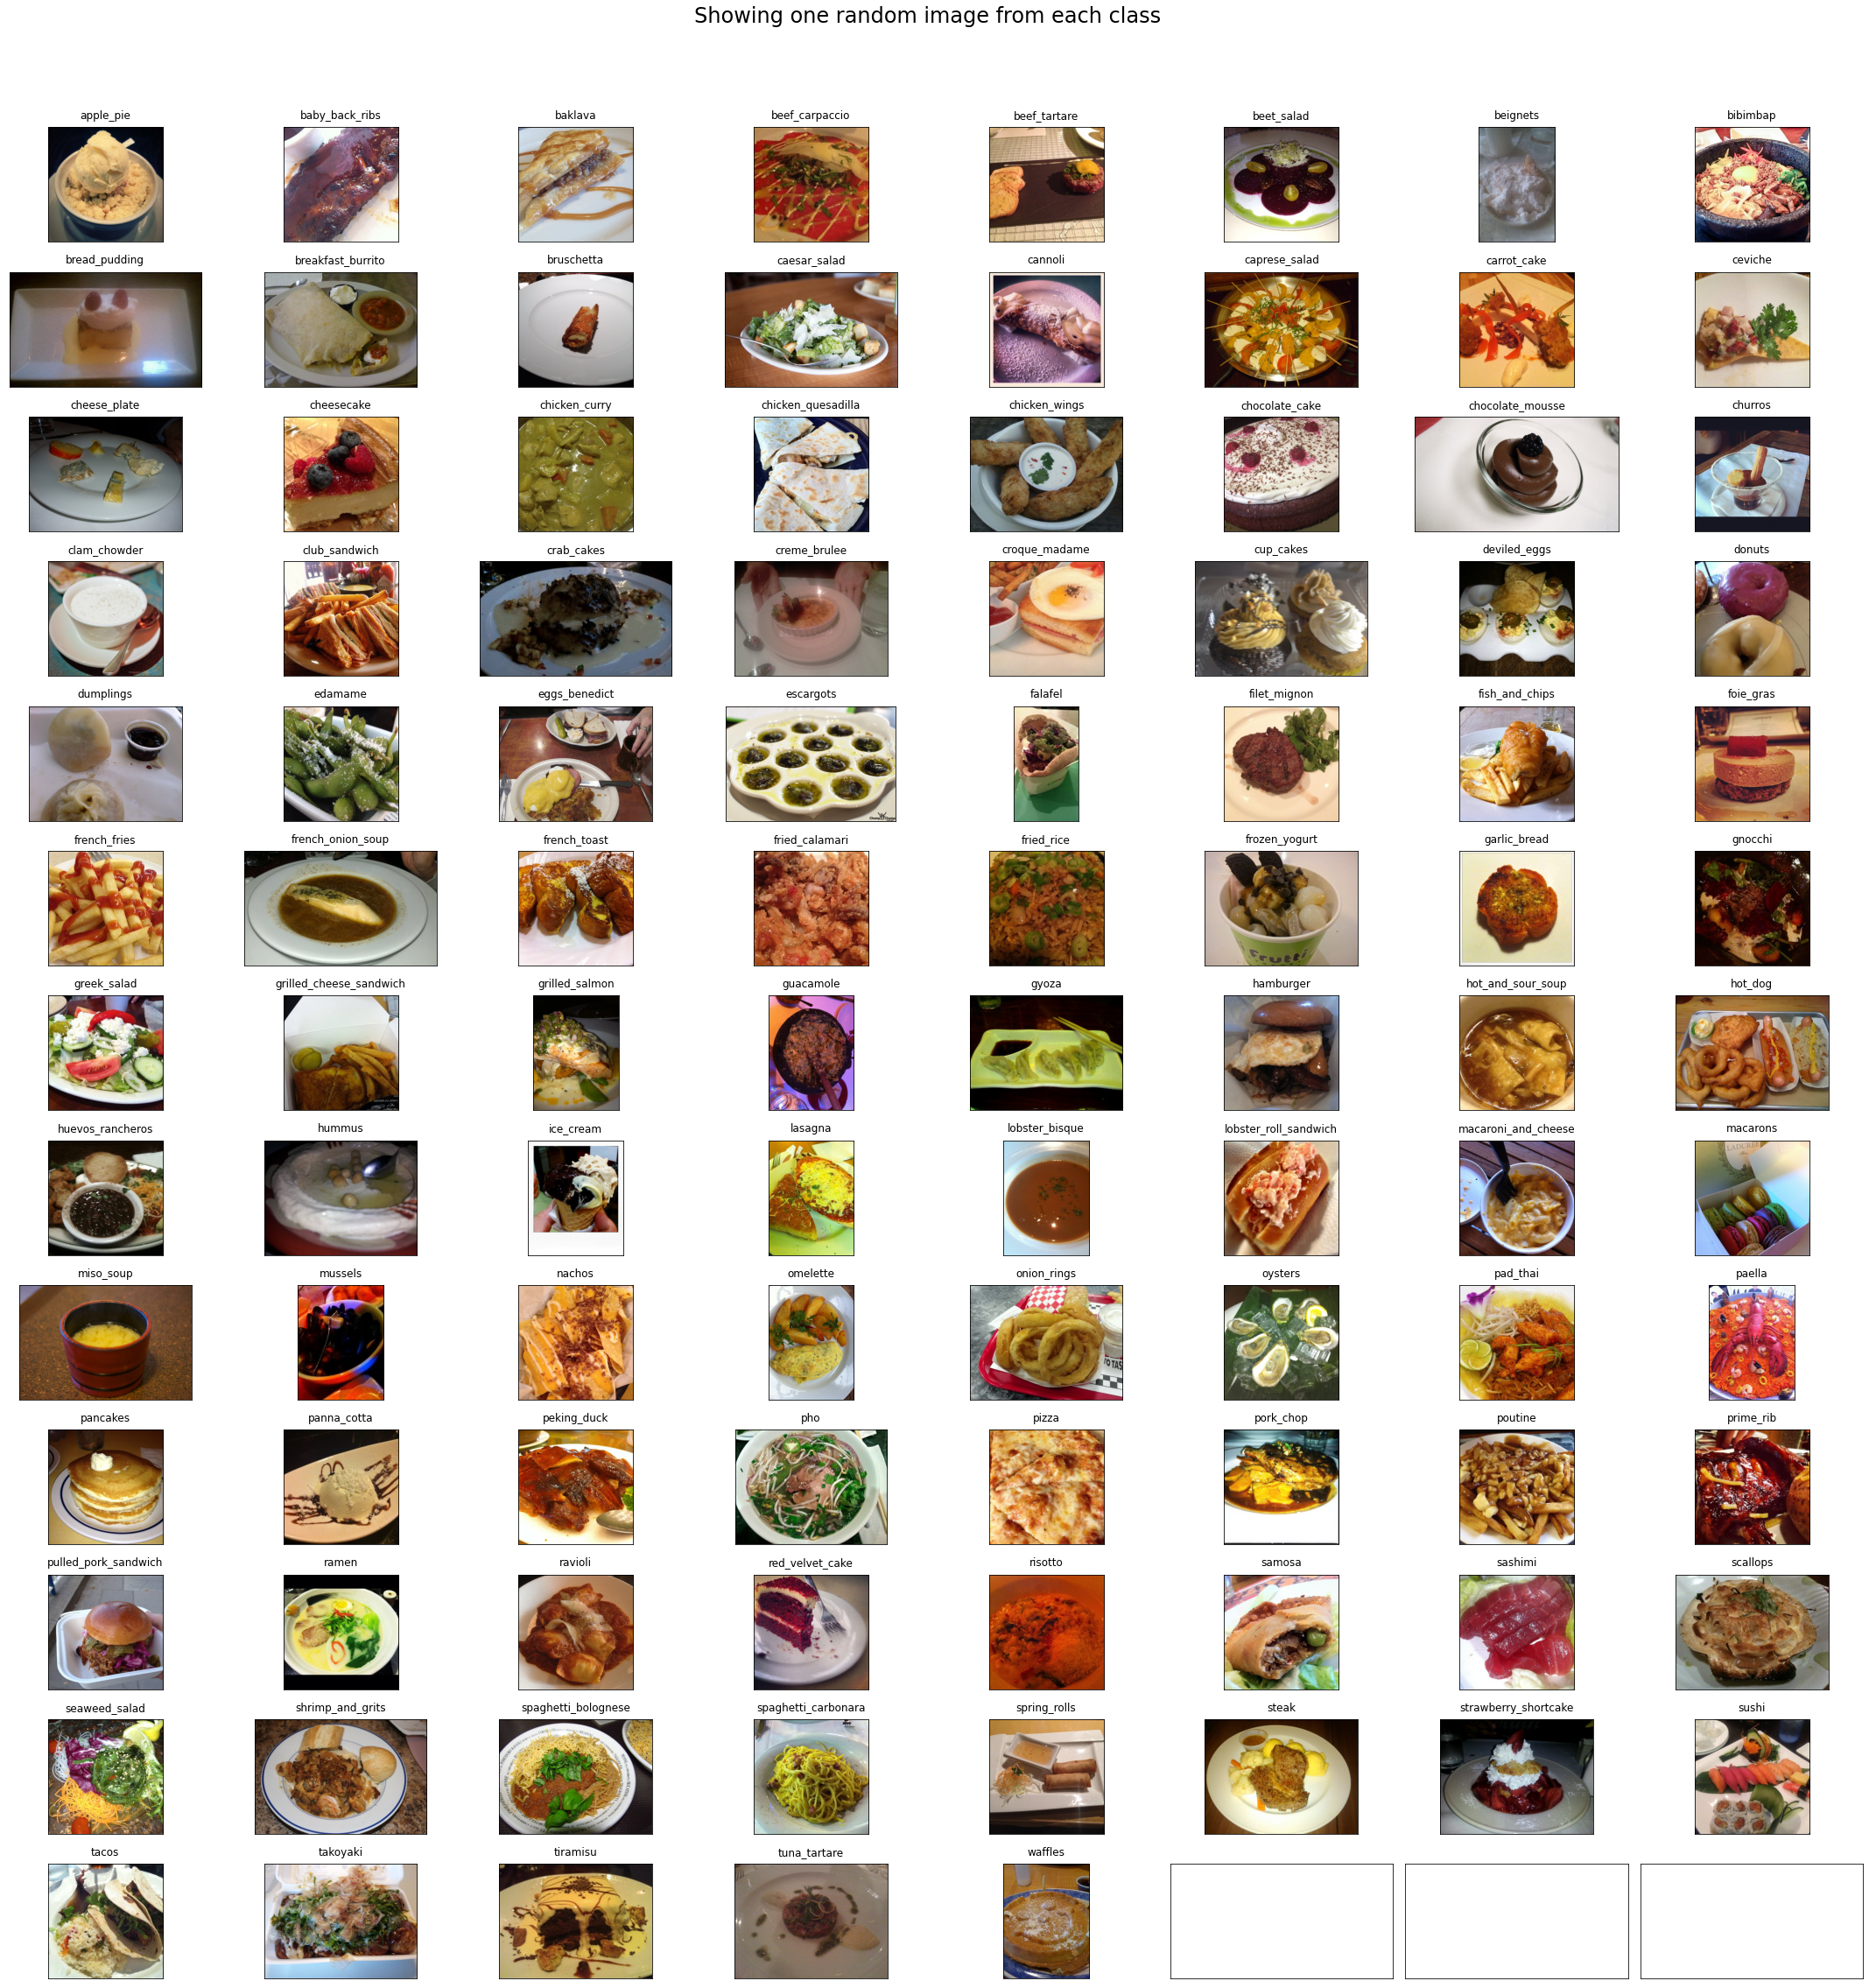

In [31]:
rows = 13
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(30,30))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

#### Re-arrange dataset into training and testing folders using tran.txt and test.txt.


In [33]:
# Function to re-arrange the dataset
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

#### Prepare train dataset folder by copying images from food-101/images to food-101/train using the file train.txt

In [ ]:
# create training data
%cd /
print("Creating train data...")
prepare_data('/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta/train.txt', '/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/images', '/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

#### Prepare test data by copying images from food-101/images to food-101/test using the file test.txt

In [ ]:
# create testing data

print("Creating test data...")
prepare_data('/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/meta/test.txt', '/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/images', '/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/test')

### 4. List number of samples in training and testing folders.

In [ ]:
print("Total number of samples in train folder")
!find /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
find: ‘/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/train’: No such file or directory
0


In [ ]:
print("Total number of samples in test folder")
!find /content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/test -type d -or -type f -printf '.' | wc -c


Total number of samples in test folder
find: ‘/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/test’: No such file or directory
0


### 5. Plot sample images from training and testing datasets.

#### Samples from Train dataset

In [ ]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/train"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

#### Samples from Test Dataset

In [ ]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class of Test Dataset", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/drive/MyDrive/Colab_Notebooks/food-101/data/food-101/test"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

# Pre-process Images
## Objectives
1. Implement preprocessing codes for each model. 
2. Augment the dataset. 
3. Preview the preprocessed dataset. 

### Your Response/Notes

You can summarize your work for this section here/give any explanations if required. 


### Preprocessing steps for light model


### Preprocessing steps for medium model

### Preprocessing steps for heavier model

# Training different models
## Objectives
1. Obtain 90% accuracy in all the models trained. 
2. You're free to use any techniques for traning such as transfer learning, knowledge transfer, etc. 
3. The models should not overfit the training dataset. 
4. Measure the performance in terms of accuracy and speed of each model. 
5. Visualize the training and testing performance using TensorBoard. 

#### Optional:
1. Apply weight quantization to increase the speed of the models. 

### Your Response/Notes

You can summarize your work for this section here/give any explanations if required. 


## Train Light model

## Train Medium model

## Train heavy model